# Hands-on session: Analysis of Higgs data

In [1]:
%reload_ext custom_magics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from custom_functions import *

In [3]:
num_workers = 5
spark = %sc $num_workers

from pyspark.sql import SparkSession

spark_session = SparkSession(spark)

# check if spark is there
spark

Exception in thread Thread-3:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 126, in run
    self.onrecv(msg)
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 143, in onrecv
    sendToFrontEnd({
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 223, in sendToFrontEnd
    monitor.send(msg)
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 57, in send
    self.comm.send(msg)
AttributeError: 'ScalaMonitor' object has no attribute 'comm'


<SparkContext master=k8s://https://192.168.2.39:6443 appName=jupyter-marchisi01>

## Prepare the input data

In [4]:
inputFile = "file:///home/jovyan/Higgs100k.parquet"
# inputFile = "file:///home/jovyan/Higgs1M.parquet"
# inputFile = "file:///home/jovyan/Higgs10M.parquet"

%time df = spark_session.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)


CPU times: user 4.26 ms, sys: 2.12 ms, total: 6.38 ms
Wall time: 3.8 s


In [5]:
total_events = df.count()
print("There are " + str(total_events) + " events")

There are 99999 events


## Feature engineering

### QUESTION 1: 

- Is the dataset unbalanced? 
- Do we need undersampling? 
- Do we need special preprocessing?

In [6]:
# Check the distribution of signal vs background
label_counts = df.groupBy("label").count().toPandas()
print("Label distribution:")
# print(label_counts)
label_counts

Label distribution:


,label,count
0,0.0,47166
1,1.0,52833


In [7]:
# Calculate the ratio
signal_count = label_counts[label_counts["label"] == 1]["count"].values[0]
background_count = label_counts[label_counts["label"] == 0]["count"].values[0]
ratio = signal_count / background_count

print(f"Signal events: {signal_count}")
print(f"Background events: {background_count}")
print(f"Signal/Background ratio: {ratio:.3f}")

Signal events: 52833
Background events: 47166
Signal/Background ratio: 1.120


### QUESTION 2: 

- Split the dataset into 5 roughly equal parts with random events

In [8]:
# Use randomSplit to divide the data into 5 equal parts
splits = df.randomSplit([0.2, 0.2, 0.2, 0.2, 0.2], seed=42)

# Verify the splits
for i, split in enumerate(splits):
    print(f"Part {i + 1}: {split.count()} events")

Part 1: 20079 events
Part 2: 20125 events
Part 3: 20088 events
Part 4: 19921 events
Part 5: 19786 events


### QUESTION 3: 
- split the dataset for training and test

In [9]:
# Split into 80% training and 20% test
train, test = df.randomSplit([0.8, 0.2], seed=42)

print(f"Events for training: {train.count()}")
print(f"Events for test: {test.count()}")

Events for training: 80213
Events for test: 19786


### QUESTION 4:

- Create the input feature vector for MLLib
- Documentation on how to do data preprocessing in Spark: https://spark.apache.org/docs/latest/ml-features.html

In [10]:
from pyspark.ml.feature import VectorAssembler

# Get all feature columns (all columns except 'label')
feature_cols = train.columns.copy()
feature_cols.remove("label")

print(f"Features: {feature_cols}")
print(f"Number of features: {len(feature_cols)}")

Features: ['lepton_pT', 'lepton_eta', 'lepton_phi', 'missing_energy_magnitude', 'missing_energy_phi', 'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_b-tag', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_b-tag', 'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_b-tag', 'jet4_pt', 'je4_eta', 'jet4_phi', 'jet4_b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
Number of features: 28


In [11]:
# VectorAssembler combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transform both train and test datasets
train = assembler.transform(train)
test = assembler.transform(test)

# Verify the transformation
display(train)
# print("Sample of features column:")
# train.select("features", "label").show(3, truncate=False)

DataFrame[label: double, lepton_pT: double, lepton_eta: double, lepton_phi: double, missing_energy_magnitude: double, missing_energy_phi: double, jet1_pt: double, jet1_eta: double, jet1_phi: double, jet1_b-tag: double, jet2_pt: double, jet2_eta: double, jet2_phi: double, jet2_b-tag: double, jet3_pt: double, jet3_eta: double, jet3_phi: double, jet3_b-tag: double, jet4_pt: double, je4_eta: double, jet4_phi: double, jet4_b-tag: double, m_jj: double, m_jjj: double, m_lv: double, m_jlv: double, m_bb: double, m_wbb: double, m_wwbb: double, features: vector]

## ML with pyspark

- Try to solve the signal vs background classification problem using a **new model of your choice** (obviously, not GBT or MCP)
- Documentation at: https://spark.apache.org/docs/3.2.1/ml-classification-regression.html

Fit the model on the **training dataset**: (dataframe train)

In [13]:
# Using Random Forest Classifier
from pyspark.ml.classification import RandomForestClassifier

# Create the Random Forest model
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=20,  # Number of trees in the forest
    maxDepth=5,  # Maximum depth of trees
    seed=42,
)


In [14]:
# Train the model
%time rf_model = rf.fit(train)

CPU times: user 22.2 ms, sys: 7.45 ms, total: 29.7 ms
Wall time: 10.1 s


### QUESTION 5: 

- Compute the accuracy/AUC/relevant metrics on the test dataset

In [15]:
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator,
)

# Make predictions on test data
result = rf_model.transform(test)


In [16]:
# AUC (Area Under ROC Curve)
auc_evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    metricName="areaUnderROC",
)
auc = auc_evaluator.evaluate(result)
print(f"Test set AUC = {auc:.4f}")


Test set AUC = 0.7351


In [17]:
# # Area Under PR Curve
# pr_evaluator = BinaryClassificationEvaluator(
#     labelCol="label",
#     metricName="areaUnderPR",
# )
# pr_auc = pr_evaluator.evaluate(result)
# print(f"Test set PR-AUC = {pr_auc:.4f}")

In [18]:
# Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy",
)
accuracy = accuracy_evaluator.evaluate(result)
print(f"Test set Accuracy = {accuracy:.4f}")

Test set Accuracy = 0.6712


In [19]:
# F1 Score
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1",
)
f1 = f1_evaluator.evaluate(result)
print(f"Test set F1 Score = {f1:.4f}")

Test set F1 Score = 0.6676


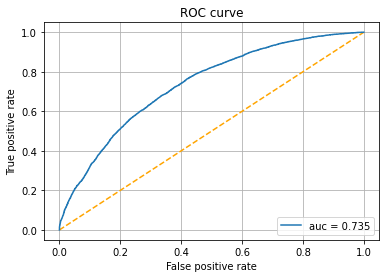

In [20]:
# Draw ROC curve
drawROC(result)

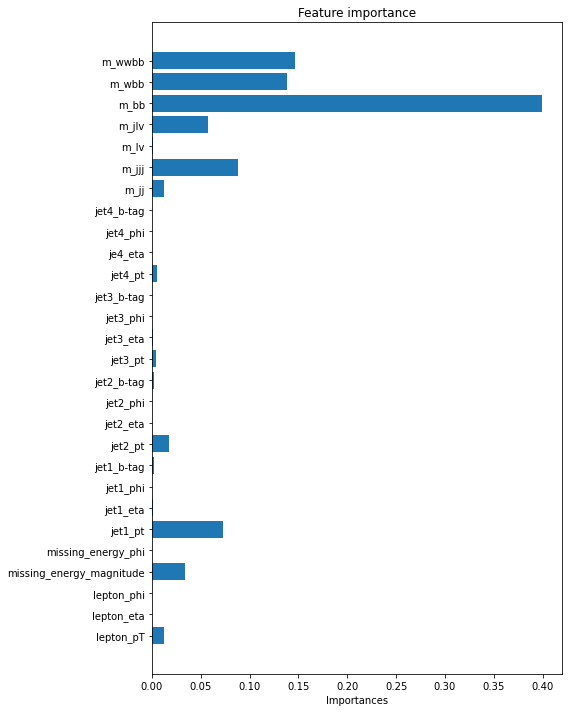

In [21]:
# Plot feature importance
drawFeatures(feature_cols, rf_model)

### QUESTION 6: 

- Check that you are neither underfitting nor overfitting

In [22]:
# Compute metrics on TRAINING data
result_train = rf_model.transform(train)

In [23]:
# AUC on training
train_auc = auc_evaluator.evaluate(result_train)
print(f"Training set AUC = {train_auc:.4f}")
print(f"Test set AUC = {auc:.4f}")

Training set AUC = 0.7483
Test set AUC = 0.7351


In [24]:
# Accuracy on training
train_accuracy = accuracy_evaluator.evaluate(result_train)
print(f"\nTraining set Accuracy = {train_accuracy:.4f}")
print(f"Test set Accuracy = {accuracy:.4f}")


Training set Accuracy = 0.6781
Test set Accuracy = 0.6712



--- Overfitting Analysis ---
AUC gap (train - test): 0.0132
Accuracy gap (train - test): 0.0070

 Model appears well-balanced (no significant overfitting or underfitting)


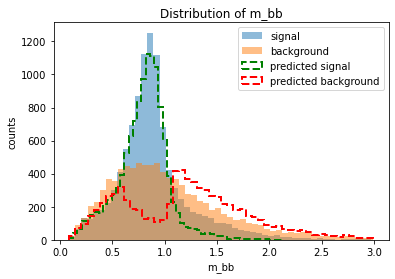

In [25]:
# Calculate the gap
auc_gap = train_auc - auc
accuracy_gap = train_accuracy - accuracy

print(f"\n--- Overfitting Analysis ---")
print(f"AUC gap (train - test): {auc_gap:.4f}")
print(f"Accuracy gap (train - test): {accuracy_gap:.4f}")

# Interpretation
if auc_gap > 0.1:
    print("\n Warning: Significant gap detected - possible OVERFITTING")
    print("Consider: reducing maxDepth, reducing numTrees, or using regularization")
elif auc < 0.6:
    print("\n Warning: Low AUC - possible UNDERFITTING")
    print("Consider: increasing maxDepth, increasing numTrees, or adding more features")
else:
    print("\n Model appears well-balanced (no significant overfitting or underfitting)")

# Plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result, "m_bb")

# Hyperparameter scan

In [26]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit

tuning_rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    seed=42,
)

In [27]:
# Build parameter grid for hyperparameter tuning
paramGrid = (
    ParamGridBuilder()
    .addGrid(tuning_rf.numTrees, [10, 20, 30, 50])
    .addGrid(tuning_rf.maxDepth, [2, 5, 10, 15, 20])
    .build()
)
print(f"Number of parameter combinations: {len(paramGrid)}")

Number of parameter combinations: 20


In [28]:
# create subsample for crossvalidator training
subSample = train.sample(fraction=1.0 / 10, withReplacement=False).cache()
print("We will use " + str(subSample.count()) + " events for the grid search")

We will use 8037 events for the grid search


In [29]:
# Create evaluator for tuning
tuning_evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    metricName="areaUnderROC",
)

In [30]:
# # Instantiate cross validation
# tuning_cv = CrossValidator(
#     estimator=tuning_rf,
#     evaluator=tuning_evaluator,
#     estimatorParamMaps=paramGrid,
#     numFolds=5,
#     parallelism=num_workers,
# )

In [31]:
# Instantiate train validation split
tuning_tvs = TrainValidationSplit(
    estimator=tuning_rf,
    estimatorParamMaps=paramGrid,
    evaluator=tuning_evaluator,
    trainRatio=0.8,
)

In [32]:
# Perform cross validation
# %time cvModel = tuning_cv.fit(train)
# %time cvModel = tuning_cv.fit(train)

In [33]:
# Perform train validation split
%time tvs_model = tuning_tvs.fit(train)
# %time tvs_model = tuning_tvs.fit(subSample)

CPU times: user 738 ms, sys: 351 ms, total: 1.09 s
Wall time: 8min 18s


In [34]:
print("Best Model hyperparameters: ")
print("NumTrees = " + str(tvs_model.bestModel._java_obj.getNumTrees()))
print("maxDepth = " + str(tvs_model.bestModel._java_obj.getMaxDepth()))

Best Model hyperparameters: 
NumTrees = 50
maxDepth = 15


In [35]:
result = tvs_model.transform(test)

evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(result)))

Test set AUC = 0.7838478989238571


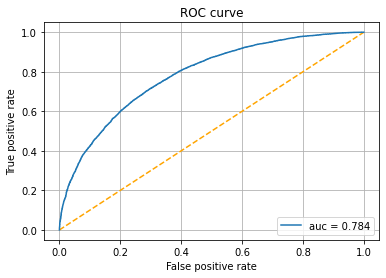

In [36]:
# make ROC curve with best model
drawROC(result)


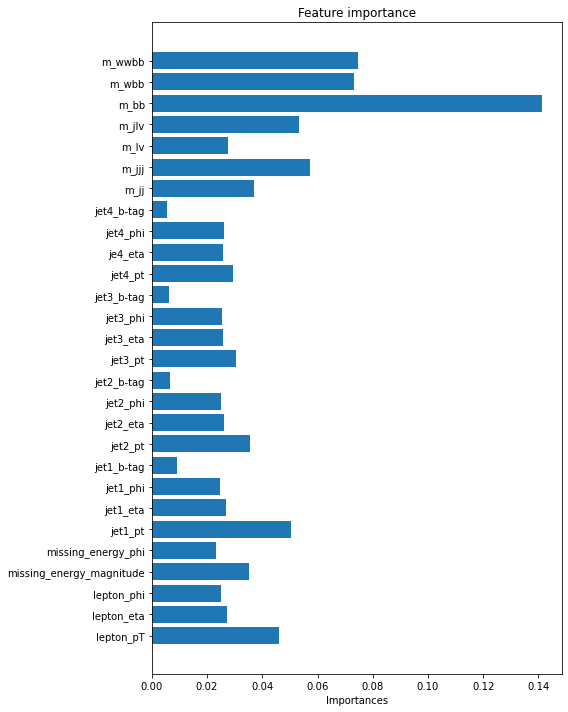

In [37]:
# plot features vs importance
drawFeatures(feature_cols, tvs_model.bestModel)


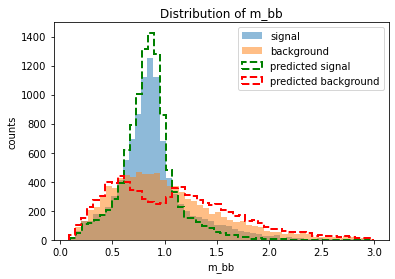

In [40]:
# plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result, "m_bb")

# Train best model on full dataset


In [41]:
inputFile = "file:///home/jovyan/Higgs10M.parquet"

%time df_final = spark_session.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

total_events = df_final.count()
print("There are " + str(total_events) + " events")

CPU times: user 2.09 ms, sys: 3.08 ms, total: 5.17 ms
Wall time: 246 ms
There are 10000000 events


In [42]:
# Split into 80% training and 20% test
train, test = df_final.randomSplit([0.8, 0.2], seed=42)

print(f"Events for training: {train.count()}")
print(f"Events for test: {test.count()}")

Events for training: 8000609
Events for test: 1999391


In [43]:
from pyspark.ml.feature import VectorAssembler

# Get all feature columns (all columns except 'label')
feature_cols = train.columns.copy()
feature_cols.remove("label")

print(f"Features: {feature_cols}")
print(f"Number of features: {len(feature_cols)}")

Features: ['lepton_pT', 'lepton_eta', 'lepton_phi', 'missing_energy_magnitude', 'missing_energy_phi', 'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_b-tag', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_b-tag', 'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_b-tag', 'jet4_pt', 'je4_eta', 'jet4_phi', 'jet4_b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
Number of features: 28


In [44]:
# VectorAssembler combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transform both train and test datasets
train = assembler.transform(train)
test = assembler.transform(test)

# Verify the transformation
display(train)

DataFrame[label: double, lepton_pT: double, lepton_eta: double, lepton_phi: double, missing_energy_magnitude: double, missing_energy_phi: double, jet1_pt: double, jet1_eta: double, jet1_phi: double, jet1_b-tag: double, jet2_pt: double, jet2_eta: double, jet2_phi: double, jet2_b-tag: double, jet3_pt: double, jet3_eta: double, jet3_phi: double, jet3_b-tag: double, jet4_pt: double, je4_eta: double, jet4_phi: double, jet4_b-tag: double, m_jj: double, m_jjj: double, m_lv: double, m_jlv: double, m_bb: double, m_wbb: double, m_wwbb: double, features: vector]

In [47]:
from pyspark.ml.classification import RandomForestClassifier

# Create the Random Forest model
# if train validation split was skipped, use these as default values instead:
# numTrees = 50
# MaxDepth = 15
rf_final = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=tvs_model.bestModel._java_obj.getNumTrees(),  # Number of trees in the forest
    maxDepth=tvs_model.bestModel._java_obj.getMaxDepth(),  # Maximum depth of trees
    seed=42,
)


In [48]:
# Train the model
%time rf_model_final = rf_final.fit(train)


CPU times: user 95.1 ms, sys: 63.7 ms, total: 159 ms
Wall time: 15min 7s


In [49]:
result_final = rf_model_final.transform(test)

In [54]:
auc_final = auc_evaluator.evaluate(result_final)
print(f"Test set AUC = {auc_final:.4f}")
accuracy_final = accuracy_evaluator.evaluate(result_final)
print(f"Test set Accuracy = {accuracy_final:.4f}")
f1_final = f1_evaluator.evaluate(result_final)
print(f"Test set F1-score = {f1_final:.4f}")

Test set AUC = 0.8066
Test set Accuracy = 0.7287
Test set F1-score = 0.7284


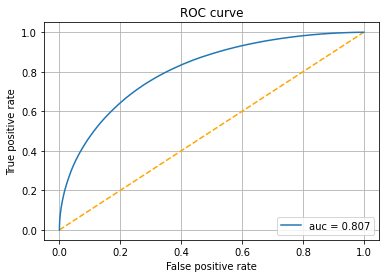

In [51]:
# make ROC curve with best model trained on whole 10M dataset
drawROC(result_final)


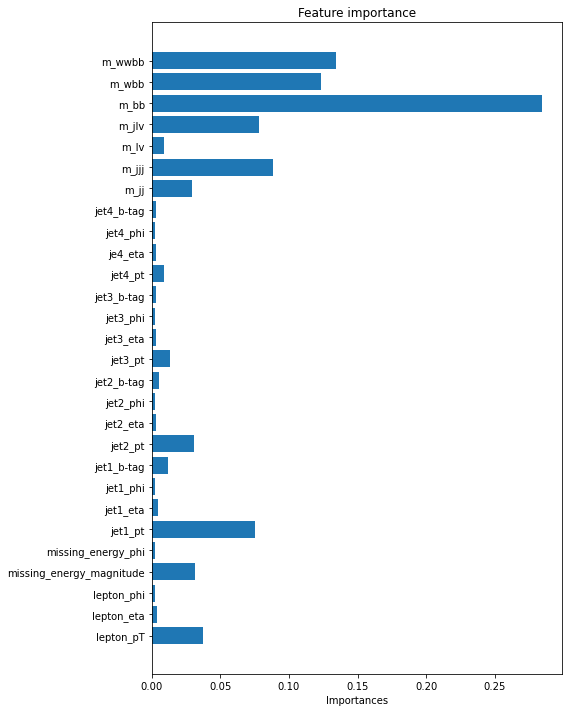

In [52]:
# Plot feature importance
drawFeatures(feature_cols, rf_model_final)

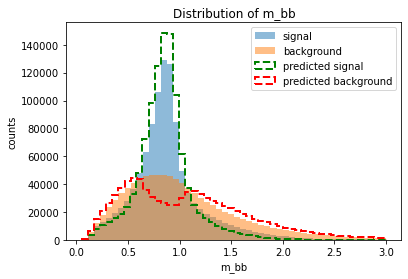

In [53]:
# Plot background vs signal with prediction
plotSignalvsBgWithPrediction(test, result_final, "m_bb")

In [55]:
# When you're done, stop spark
spark.stop()

### Final results

Pick any two models (can be any from pyspark MLLib, Keras + BigDL sequential) and  (you can use results from previous days):
- Compare them in terms of absolute performances. Discuss accuracy, ROC, AUC, feature importance, feature distributions. Which of these metrics do you deem more critical?
- Compare how they scale in terms of performances and training time when you change the number of executors (from 1 to 5)
- Discuss the results.  
- You can also collect results in external documents (google documents, pdf, whatever) and link them here